In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import os, sys
import pandas as pd

root = '/usr/local/serenceslab/maggie/shapeDim/'

sys.path.append(os.path.join(root, 'Analysis'))
from code_utils import data_utils
from code_utils import stats_utils, plot_utils


In [3]:
task_names = ['Linear (1)','Linear (2)','Checker', 'Repeat'];
n_tasks = len(task_names)
task_colors = np.flipud(cm.GnBu(np.linspace(0,1,5))[1:,:])

n_subjects = 7
subjects = np.arange(1,8)
subcolors = cm.Dark2(np.linspace(0,1,n_subjects))

In [4]:
lab = dict()
for ss in subjects:
    
    # get labels for all the trials, this subject
    main_labels = data_utils.load_main_task_labels(ss)
    rep_labels = data_utils.load_repeat_task_labels(ss)
    lab[ss] = pd.concat([main_labels, rep_labels], axis=0)
   

In [5]:
from code_utils import grid_utils
grid_pts = grid_utils.get_main_grid()
# NOTE i am swapping the columns here
# because this is the order you get from doing np.unique(pts)
# this is the actual order that the predictions 1-16 of this classifier
# correspond to. 
grid_pts = grid_pts[:,[1,0]] 

In [6]:
save_folder = os.path.join(root, 'Analysis', 'decoding_results')
save_filename = os.path.join(save_folder, 'decode_multiclass_withintask.npy')
dec_withintask = np.load(save_filename, allow_pickle=True).item()
dec_withintask.keys()
roi_names = dec_withintask['roi_names']
roi_names[-1] = 'IPS'
n_rois = len(roi_names)

#### compute bootstrapped CIs for the correct/incorrect difference
on hard trials only

the actual computation is done in bootstrap_confidence.py (i saved it to disk because it takes ~10 minutes to run)

In [7]:
from multinomial_decoding import bootstrap_confidence
# bootstrap_confidence.bootstrap_correct_incorrect(n_boot_iter=1000)

In [10]:
save_folder = os.path.join(root, 'Analysis', 'decoding_results')
fn2load = os.path.join(save_folder, 'decode_multiclass_sepcorrect_bootstrap.npy')
print(fn2load)

b = np.load(fn2load, allow_pickle=True).item()
b.keys()
signedconf_hardtrials_sepcorrect_boot = b['signedconf_hardtrials_sepcorrect_boot']

/usr/local/serenceslab/maggie/shapeDim/Analysis/decoding_results/decode_multiclass_sepcorrect_bootstrap.npy


In [11]:
signedconf_hardtrials_sepcorrect_boot.shape

(7, 8, 3, 2, 1000)

In [12]:
plt.rcParams['pdf.fonttype']=42
plot_utils.set_all_font_sizes(fs = 16)
figfolder = os.path.join(root, 'Analysis','figures')

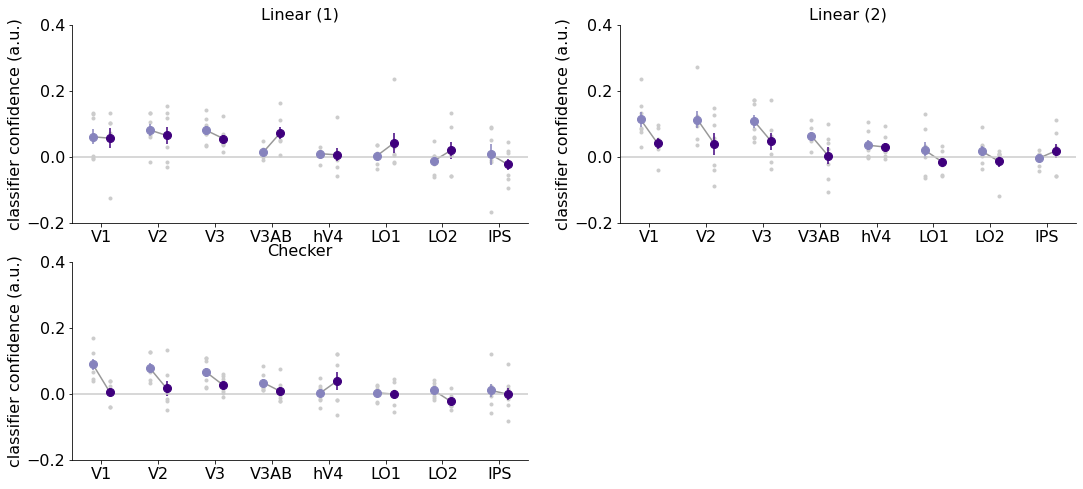

In [13]:
vals = np.mean(signedconf_hardtrials_sepcorrect_boot, axis=4)
meanvals = np.mean(vals, axis=0)
semvals = np.std(vals, axis=0)/np.sqrt(n_subjects)


colors = cm.Purples(np.linspace(0,1,6))[[3,5],:]

x_jitter = np.linspace(-0.15, 0.15, 2)

plt.figure(figsize=(18,8))

for ti in [0,1,2]:
    
    ax = plt.subplot(2,2,ti+1)
    
    plt.axhline(0, color=[0.8, 0.8, 0.8])
    
    lh = []
    
    for ci in [0,1]:
        
        x_ticks = np.arange(n_rois) + x_jitter[ci]
    
        plt.plot(x_ticks, meanvals[:,ti,ci], 'o', color=colors[ci], markersize=8, alpha=1)
        h = plt.errorbar(x_ticks, meanvals[:,ti,ci], \
                         semvals[:,ti,ci], \
                         xerr=None, color=colors[ci], linestyle='none')
        lh.append(h)
        
    for ri in range(n_rois):
            
        plt.plot(ri+x_jitter, meanvals[ri,ti,:],'-',color=[0.6, 0.6, 0.6], zorder=-5)
        
        plt.plot(ri+x_jitter, vals[:,ri,ti,:].T, '.', color=[0.8, 0.8, 0.8], zorder=-10)
        # if non_overlapping[ri]:
        #     yval = np.max(cihigh[ri,ti,:])+0.02
        #     plt.annotate('*',[ri,yval])

    plt.ylim([-0.20, 0.40])
    # plt.ylim([-0.05, 0.20])
    
    plt.xticks(np.arange(n_rois), roi_names)
    plt.ylabel('classifier confidence (a.u.)')
    
    # plt.legend(lh,['subject correct','subject incorrect'])
    
    plt.title(task_names[ti])
    
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    
# plt.suptitle('Hard trials: classifier confidence')

figname = os.path.join(figfolder, 'correct_vs_incorrect.pdf')
plt.savefig(figname)


In [15]:
tnames = ['linear1','linear2','checker']

for ti, taskname in enumerate(tnames):

    vals = np.mean(signedconf_hardtrials_sepcorrect_boot, axis=4)[:,:,ti,:]

    anova_result = stats_utils.rmanova_2way(vals, ['ROI','Correctness'], \
                                            do_shuffle=True, n_iter=10000, rndseed = 143242)
    
    tablename = os.path.join(figfolder, 'correctness_rm_anova_%s.csv'%(taskname))
    
    print(tablename)
    anova_result.to_csv(tablename)

/usr/local/serenceslab/maggie/shapeDim/Analysis/figures/correctness_rm_anova_linear1.csv
/usr/local/serenceslab/maggie/shapeDim/Analysis/figures/correctness_rm_anova_linear2.csv
/usr/local/serenceslab/maggie/shapeDim/Analysis/figures/correctness_rm_anova_checker.csv


In [14]:
tnames = ['linear1','linear2','checker']

for ti, taskname in enumerate(tnames):
    print(taskname)
    tablename = os.path.join(figfolder, 'correctness_rm_anova_%s.csv'%(taskname))
    print(tablename)
    anova_result = pd.read_csv(tablename, index_col=0)
    print(anova_result)

linear1
/usr/local/serenceslab/maggie/shapeDim/Analysis/figures/correctness_rm_anova_linear1.csv
                  F Value  Num DF  Den DF    Pr > F  p (permutation)
ROI              4.447959     7.0    42.0  0.000895           0.0007
Correctness      0.202045     1.0     6.0  0.668857           0.6644
ROI:Correctness  1.098006     7.0    42.0  0.382075           0.3818
linear2
/usr/local/serenceslab/maggie/shapeDim/Analysis/figures/correctness_rm_anova_linear2.csv
                  F Value  Num DF  Den DF    Pr > F  p (permutation)
ROI              5.574093     7.0    42.0  0.000138           0.0002
Correctness      8.041212     1.0     6.0  0.029734           0.0297
ROI:Correctness  1.956937     7.0    42.0  0.084333           0.0827
checker
/usr/local/serenceslab/maggie/shapeDim/Analysis/figures/correctness_rm_anova_checker.csv
                  F Value  Num DF  Den DF    Pr > F  p (permutation)
ROI              3.581338     7.0    42.0  0.004137           0.0037
Correctness      8.

In [15]:
for ti in range(3):

    vals = np.mean(signedconf_hardtrials_sepcorrect_boot, axis=4)[:,:,ti,:]

    tstats_correctness = np.zeros((n_rois,),dtype=float)
    pvals_correctness = np.zeros((n_rois,),dtype=float)
    
    n_subs_samedir = np.zeros((n_rois,),dtype=int)

    rndseed = 3535445
    for rr in range(n_rois):

        c1_values = vals[:,rr,0]
        c2_values = vals[:,rr,1]

        p, t = stats_utils.paired_ttest_nonpar(c1_values, c2_values, \
                                               n_iter=10000, rndseed=rndseed+rr)    
        pvals_correctness[rr] = p
        tstats_correctness[rr] = t

        subj_diffs = c1_values - c2_values
        n_subs_samedir[rr] = np.maximum(np.sum(subj_diffs>0), np.sum(subj_diffs<0))


    corr_df = pd.DataFrame({'t-stat for correct > incorrect': tstats_correctness, \
                            'pvalue': pvals_correctness, \
                            'n_subs_indiv': n_subs_samedir}, \
                              index=roi_names)
    corr_df = corr_df.round(3)
    
    print('\n%s'%task_names[ti])
    print(corr_df)


Linear (1)
      t-stat for correct > incorrect  pvalue  n_subs_indiv
V1                             0.093   0.942             5
V2                             0.608   0.639             4
V3                             1.187   0.309             4
V3AB                          -2.844   0.028             6
hV4                            0.140   0.816             6
LO1                           -0.981   0.459             4
LO2                           -0.819   0.385             5
IPS                            1.046   0.325             5

Linear (2)
      t-stat for correct > incorrect  pvalue  n_subs_indiv
V1                             2.896   0.062             5
V2                             2.487   0.089             5
V3                             1.955   0.129             4
V3AB                           1.840   0.167             4
hV4                            0.677   0.531             5
LO1                            1.158   0.360             4
LO2                            0